# Экспериментальная лингвистика

*Комментарии к использованию моделей:*

*Линейные модели: lm и lmer - используем для величин, которые имеют нормальное распределение*

*Генерализованные линейные модели: glm и glmer - используем для величин, распределение которых отличается от нормального (например, бинарные величины)*

*Для моделей lmer и glmer можно указать random effects в виде (1\|variable), если предполагаем, что вариативность самой величины variable может влиять на результат, или (1 + variable1\|variable2), если мы предполагаем, что вариативность величины variable1 может зависеть от величины variable2, что также может оказать значимый эффект на изменения зависимой переменной*


## Домашнее задание 4

Задание: на основании данных эксперимента

• Построить основную и альтернативную гипотезу (одну или несколько) о закономерностях, наблюдаемых в данных

• Проверить гипотезу с помощью линейной и генерализованной линейной модели, прокомментировать результаты


In [185]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2
import seaborn as sns

In [186]:
# данные экспериментов
df = pd.read_excel('data_lecture_3_tACS.xlsx')
df.head()

,participant,stim_order,condition,AL,L1,answer,score,RT,task,session
0,0,RS,real,derartu,samolet,down,1.0,2.541925,AFC,train
1,0,RS,real,asamu,shprits,right,1.0,1.794262,AFC,train
2,0,RS,real,farimu,konvert,down,1.0,1.989078,AFC,train
3,0,RS,real,vortule,roza,left,1.0,1.904852,AFC,train
4,0,RS,real,topeme,terka,right,1.0,1.839869,AFC,train


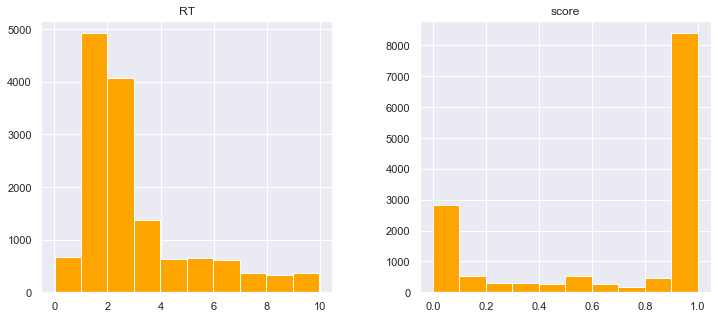

In [187]:
sns.set(rc={'figure.figsize':(12,5)})

ax=df[['score','RT']].hist(color='orange' )

In [188]:
# мета-данные
meta_df = pd.read_excel('data_tACS_meta.xlsx', names=['id','sex','age',
                                                      'languages','degree','years','lefthand','family_lefthand'])
meta_df.head()

,id,sex,age,languages,degree,years,lefthand,family_lefthand
0,0,m,33,"Английский, немецкий",Высшее,16.0,нет,нет
1,1,m,25,"Английский: B1, немецкий: А1, белорусский: B1",Высшее,16.0,нет,нет
2,2,m,38,Английский: B1,Высшее,16.0,нет,Да
3,3,f,22,"Английский: С1, китайский: начальный, итальянс...",Высшее,16.0,нет,нет
4,4,f,22,Английский: B1,Высшее,15.5,нет,нет


In [189]:
meta_df.shape

(30, 8)

### Гипотезы:

Возьму для рассмотрения пары гипотез, которую уже проверяла в прошлом дз №3.

(1) чем больше языков человек учил - тем более у него развиты соответствующие навыки и тем выше будут его баллы за задания.

**H0 FL~score:** кол-во знакомых участнику иностранных языков (FL >1) не коррелирует с точностью выполнения заданий (score).

**H1 FL~score:** кол-во знакомых участнику иностранных языков >1 коррелирует с точностью выполнения заданий.

(2) чем дольше человек думает над ответом (чем больше RT), тем неправильнее он отвечает в результате (тем меньше score); например, потому что не знает ответ и вспомнить так и не удаётся.

**H0 RT~score:** показать RT не коррелирует с показателем score.

**H1 RT~score:** показатель RT коррелирует с показателем score.

In [190]:
df.loc[df['score'] < 1, 'score'] = 0

In [191]:
# группируем интересующие нас данные экспериментов
df_selected = []

for (p_id), groupdf in df.groupby(['participant']):
    df_selected.append({'participant': p_id, 
                     'score': groupdf['score'].sum(),
                     'mean_RT': groupdf[groupdf['score'] == 1]['RT'].mean()})
    
df_selected = pd.DataFrame(df_total)
df_selected.head()

,condition,mean_RT,participant,score,session,stim_order,task,FL
0,1,1.546667,0,22.0,1,1,1,2
1,2,1.481284,0,28.0,1,1,1,2
2,1,4.878153,0,1.0,1,1,2,2
3,2,4.516147,0,1.0,1,1,2,2
4,1,1.659898,0,19.0,1,1,3,2


In [192]:
df_selected.shape

(480, 8)

In [193]:
# создаём столбец мета-данных с кол-вом ин.языков
FL_list = [len(meta_df['languages'][i].split(',')) for i in range(meta_df.shape[0])]

In [194]:
meta_df['FL'] = FL_list
meta_df.head()

,id,sex,age,languages,degree,years,lefthand,family_lefthand,FL
0,0,m,33,"Английский, немецкий",Высшее,16.0,нет,нет,2
1,1,m,25,"Английский: B1, немецкий: А1, белорусский: B1",Высшее,16.0,нет,нет,3
2,2,m,38,Английский: B1,Высшее,16.0,нет,Да,1
3,3,f,22,"Английский: С1, китайский: начальный, итальянс...",Высшее,16.0,нет,нет,3
4,4,f,22,Английский: B1,Высшее,15.5,нет,нет,1


In [195]:
# добавляем инфу о кол-ве ин.языков к данным экспериментов
df_selected_id_list = [row['participant'] for i, row in df_selected.iterrows()]

df_selected['FL'] = [int(meta_df.loc[(meta_df['id'] == id_item), 'FL']) for id_item in df_selected_id_list]

df_selected.head()

,condition,mean_RT,participant,score,session,stim_order,task,FL
0,1,1.546667,0,22.0,1,1,1,2
1,2,1.481284,0,28.0,1,1,1,2
2,1,4.878153,0,1.0,1,1,2,2
3,2,4.516147,0,1.0,1,1,2,2
4,1,1.659898,0,19.0,1,1,3,2


### Linear Model (LM) >>> FL~score

https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/09_regression.html

In [196]:
import statsmodels.api as sm

In [197]:
Y = df_selected['score']
X = df_selected['FL']

In [198]:
X = sm.add_constant(X)
X.head()

,const,FL
0,1.0,2
1,1.0,2
2,1.0,2
3,1.0,2
4,1.0,2


In [199]:
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2289
Date:                Fri, 13 Oct 2023   Prob (F-statistic):              0.633
Time:                        00:10:35   Log-Likelihood:                -1876.5
No. Observations:                 480   AIC:                             3757.
Df Residuals:                     478   BIC:                             3765.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9264      1.249     13.552      0.000      14.472      19.381
FL             0.3093      0.646      0.478      0.633      -0.961       1.579
==============================================================================
Omnibus:                     4452.858   Durbin-Watson:                   1.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.355
Skew:                          -0.269   Prob(JB):                     1.16e-11
Kurtosis:                       1.507   Cond. No.                         5.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Кэффициент корреляции score и FL = 4.9482, p-value = 0.663 > 0.05, то есть корреляция слабая и то случайная.

### Linear Model (LM) >>> RT~score

In [200]:
Y = df_selected['score']
X = df_selected['mean_RT']

In [201]:
X = sm.add_constant(X)
X.head()

,const,mean_RT
0,1.0,1.546667
1,1.0,1.481284
2,1.0,4.878153
3,1.0,4.516147
4,1.0,1.659898


In [202]:
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     869.1
Date:                Fri, 13 Oct 2023   Prob (F-statistic):          3.13e-106
Time:                        00:10:36   Log-Likelihood:                -1461.4
No. Observations:                 442   AIC:                             2927.
Df Residuals:                     440   BIC:                             2935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.8541      0.684     53.909      0.000      35.511      38.198
mean_RT       -6.2763      0.213    -29.480      0.000      -6.695      -5.858
==============================================================================
Omnibus:                       15.040   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.731
Skew:                          -0.458   Prob(JB):                     0.000384
Kurtosis:                       3.122   Cond. No.                         7.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Кэффициент корреляции score и mean_RT = 22.5853 (что в несколько раз больше, чем коэф. корреляции FL и score, например), при этом p-value = 0.581 > 0.05, то есть настоящей корреляции нет.

### Linear Mixed Effects Regression (LMER)

https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/10_multiple_regression.html

In [203]:
import statsmodels.formula.api as smf

In [204]:
# группируем интересующие нас данные экспериментов; добавляем побольше еременных
df_total = []

for (p_id, session, task, condition), groupdf in df.groupby(['participant', 'session', 'task', 'condition']):
    df_total.append({'participant': p_id, 
                     'session': session,
                     'task': task,
                     'condition': condition,
                     'stim_order': groupdf['stim_order'].unique().tolist()[0],
                     'score': groupdf['score'].sum(),
                     'mean_RT': groupdf[groupdf['score'] == 1]['RT'].mean()})
    
df_total = pd.DataFrame(df_total)

In [205]:
# кодируем значения оставшихся текстовых столбцов

def encode_values(data):
    unique_values = list(data.unique())
    dict_codes = {}

    for i, name in enumerate(unique_values):
        if name != 'NaN':
            dict_codes[name] = i+1
        else:
            dict_codes[name] = 0 # для NaN: заменяем их на 0

    return dict_codes

In [206]:
dict_condition = encode_values(df_total['condition'])
dict_session = encode_values(df_total['session'])
dict_stim_order = encode_values(df_total['stim_order'])
dict_task = encode_values(df_total['task'])

In [207]:
%%time
for i in range((df_total.shape[0])):

    df_total.loc[i, ['condition','session','stim_order','task']] = [dict_condition[df_total['condition'][i]],
                                                                dict_session[df_total['session'][i]],
                                                                dict_stim_order[df_total['stim_order'][i]],
                                                                dict_task[df_total['task'][i]]]

Wall time: 1.14 s


In [208]:
df_total_id_list = [row['participant'] for i, row in df_total.iterrows()]

df_total['FL'] = [int(meta_df.loc[(meta_df['id'] == id_item), 'FL']) for id_item in df_total_id_list]

df_total.head()

,condition,mean_RT,participant,score,session,stim_order,task,FL
0,1,1.546667,0,22.0,1,1,1,2
1,2,1.481284,0,28.0,1,1,1,2
2,1,4.878153,0,1.0,1,1,2,2
3,2,4.516147,0,1.0,1,1,2,2
4,1,1.659898,0,19.0,1,1,3,2


In [209]:
ksf =  smf.ols('score ~ condition + mean_RT + participant + session + stim_order + task + FL', data=df_total)
ksf_res = ksf.fit()
ksf_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     144.5
Date:                Fri, 13 Oct 2023   Prob (F-statistic):          3.61e-109
Time:                        00:10:38   Log-Likelihood:                -1436.5
No. Observations:                 442   AIC:                             2889.
Df Residuals:                     434   BIC:                             2922.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      31.5731      1.764     17.895      0.000      28.105      35.041
condition      -0.2555      0.600     -0.426      0.670      -1.434       0.923
mean_RT        -6.0885      0.207    -29.433      0.000      -6.495      -5.682
participant     0.0443      0.035      1.284      0.200      -0.024       0.112
session        -0.4864      0.421     -1.156      0.248      -1.313       0.340
stim_order     -0.1625      0.625     -0.260      0.795      -1.390       1.065
task            2.2407      0.329      6.819      0.000       1.595       2.887
FL              0.3080      0.373      0.826      0.409      -0.425       1.041
==============================================================================
Omnibus:                       18.359   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.475
Skew:                          -0.493   Prob(JB):                     5.90e-05
Kurtosis:                       3.294   Cond. No.                         106.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-value < 0.05 у mean_RT и task. 

При этом коэф. корреляции score и mean_RT = -6.0885, т.е. корреляция отрицательная; это должно значить, что чем больше score - тем меньше mean_RT и наоборот; значит, эти вычисления подтверждают имевшуюся гипотезу RT~score! (что странно на фоне предыдущих результатов, но ладно). 

In [210]:
print(dict_task)

{'SEM': 1, 'recall': 2, 'recognition': 3, 'AFC': 4}


Коэф. корреляции score и task = 2.2407, т.е. есть положительная корреляция; т.к. task закодированная категориальная переменная, то результаты немного сложно интерпретировать, но мы попробуем. Например, так: задания типа recognition и AFC давались участникам проще, чем другие.

Значимой корреляции score и FL не было обнаружено...

### Generalized Linear Model (GLM) >>> FL~score

In [211]:
# Fit the GLM model
glm = sm.GLM.from_formula('score ~ FL', data=df_total, family=sm.families.Gaussian())
glm_res = glm.fit()
glm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  score   No. Observations:                  480
Model:                            GLM   Df Residuals:                      478
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          146.20
Method:                          IRLS   Log-Likelihood:                -1876.5
Date:                Fri, 13 Oct 2023   Deviance:                       69882.
Time:                        00:10:38   Pearson chi2:                 6.99e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9264      1.249     13.552      0.000      14.478      19.374
FL             0.3093      0.646      0.478      0.632      -0.958       1.576
==============================================================================
"""

Кэффициент корреляции score и FL = 0.3093, при этом p-value = 0.632 > 0.05, то есть корреляция слабая да и на самом деле её нет.

### Generalized Linear Model (GLM) >>> RT~score

In [212]:
# Fit the GLM model
glm = sm.GLM.from_formula('score ~ mean_RT', data=df_total, family=sm.families.Gaussian())
glm_res = glm.fit()
glm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  score   No. Observations:                  442
Model:                            GLM   Df Residuals:                      440
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          43.795
Method:                          IRLS   Log-Likelihood:                -1461.4
Date:                Fri, 13 Oct 2023   Deviance:                       19270.
Time:                        00:10:38   Pearson chi2:                 1.93e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.8541      0.684     53.909      0.000      35.514      38.194
mean_RT       -6.2763      0.213    -29.480      0.000      -6.694      -5.859
==============================================================================
"""

Кэффициент корреляции score и mean_RT = -6.2763, при этом p-value = 0, то есть, если верить этим показателям, корреляция есть и она отрицательная, что подкрепляет гипотезу о том, что чем дольше человек думает, тем меньше его баллы. Ох уж эта неуловимая корреляция...

### Generalized Linear Mixed Effects Regression (GLMER)

In [213]:
glm = sm.GLM.from_formula('score ~ condition + mean_RT + participant + session + stim_order + task + FL', 
                          data=df_total, family=sm.families.Gaussian())
glm_res = glm.fit()
glm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  score   No. Observations:                  442
Model:                            GLM   Df Residuals:                      434
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          39.664
Method:                          IRLS   Log-Likelihood:                -1436.5
Date:                Fri, 13 Oct 2023   Deviance:                       17214.
Time:                        00:10:38   Pearson chi2:                 1.72e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      31.5731      1.764     17.895      0.000      28.115      35.031
condition      -0.2555      0.600     -0.426      0.670      -1.431       0.920
mean_RT        -6.0885      0.207    -29.433      0.000      -6.494      -5.683
participant     0.0443      0.035      1.284      0.199      -0.023       0.112
session        -0.4864      0.421     -1.156      0.248      -1.311       0.338
stim_order     -0.1625      0.625     -0.260      0.795      -1.387       1.062
task            2.2407      0.329      6.819      0.000       1.597       2.885
FL              0.3080      0.373      0.826      0.409      -0.423       1.039
===============================================================================
"""

P-value < 0.05 снова у mean_RT и task. 

При этом коэф. корреляции score и mean_RT = -6.0885 (LMER показывала точно такое же значение!);вывод по этим показателям тот же: эти вычисления подтверждают имевшуюся гипотезу RT~score! (мы продолжим закрывать глаза на несовпадение результатов разных тестов... в чём-то они всё же сходятся, хоть и не все...).

Коэф. корреляции score и task = 2.2407, остался тем же.

Значимой корреляции score и FL так и не было обнаружено :(